<a href="https://colab.research.google.com/github/EBUSYGIN/ML-3/blob/main/intensive3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
# Загрузка новых данных
test_path = "/content/sample_data/train.xlsx"
train_path = "/content/sample_data/test.xlsx"


train_data = pd.read_excel(train_path)
test_data = pd.read_excel(test_path)

In [ ]:
#Просмотр первых строк каждого набора данных
train_data.head(), test_data.head()

(          dt  Цена на арматуру
 0 2022-09-05             46000
 1 2022-09-12             46000
 2 2022-09-19             46000
 3 2022-09-26             45500
 4 2022-10-03             45500,
           dt  Цена на арматуру
 0 2015-01-05             32900
 1 2015-01-12             32500
 2 2015-01-19             32000
 3 2015-01-26             30700
 4 2015-02-02             30300)

*В 2022 году цена на арматуру была выше и более стабильной, с небольшим снижением в конце периода.*

*В 2015 году наблюдалось устойчивое снижение цен, что может указывать на разные рыночные условия (например, спрос, предложение, экономическая ситуация).*

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Проверка пропусков
missing_values = train_data.isnull().sum(), test_data.isnull().sum()

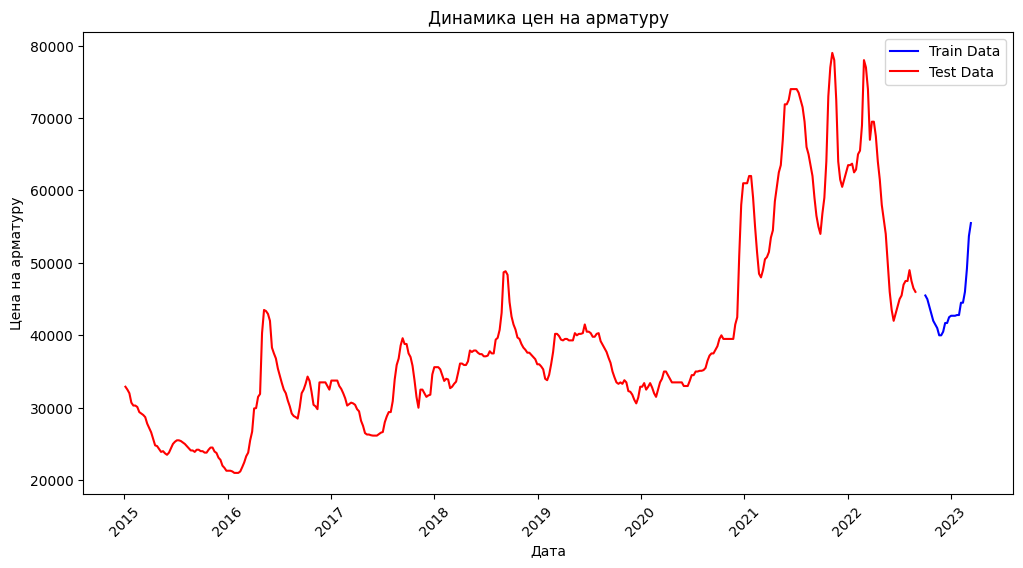

In [ ]:
# Визуализация динамики цен
plt.figure(figsize=(12, 6))
plt.plot(train_data["dt"], train_data["Цена на арматуру"], label="Train Data", color='blue')
plt.plot(test_data["dt"], test_data["Цена на арматуру"], label="Test Data", color='red')
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.legend()
plt.xticks(rotation=45)
plt.show()




*График показывает, что цены на арматуру меняются во времени*

In [ ]:
# Создание временных признаков
train_data["year"] = train_data["dt"].dt.year
train_data["month"] = train_data["dt"].dt.month
train_data["week"] = train_data["dt"].dt.isocalendar().week

# Добавление лагов и скользящего среднего
lags = [1, 2, 3, 4]  # Лаги цен на 1-4 недели назад
for lag in lags:
    train_data[f"lag_{lag}"] = train_data["Цена на арматуру"].shift(lag)

# Скользящее среднее за 4 недели
train_data["rolling_mean_4"] = train_data["Цена на арматуру"].rolling(window=4).mean()

# Удаление строк с NaN (из-за лагов)
train_data = train_data.dropna()

# Проверка итогового датасета
train_data.head()


,dt,Цена на арматуру,year,month,week,lag_1,lag_2,lag_3,lag_4,rolling_mean_4
4,2022-10-03,45500,2022,10,40,45500.0,46000.0,46000.0,46000.0,45750.0
5,2022-10-10,45000,2022,10,41,45500.0,45500.0,46000.0,46000.0,45500.0
6,2022-10-17,44000,2022,10,42,45000.0,45500.0,45500.0,46000.0,45000.0
7,2022-10-24,43000,2022,10,43,44000.0,45000.0,45500.0,45500.0,44375.0
8,2022-10-31,42000,2022,10,44,43000.0,44000.0,45000.0,45500.0,43500.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
# Определение признаков и целевой переменной
features = ["year", "month", "week", "lag_1", "lag_2", "lag_3", "lag_4", "rolling_mean_4"]
target = "Цена на арматуру"

# Разбиение данных
X_train, X_val, y_train, y_val = train_test_split(train_data[features], train_data[target], test_size=0.2, random_state=42, shuffle=False)

# Обучение модели
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогноз и оценка качества
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mae


5418.8

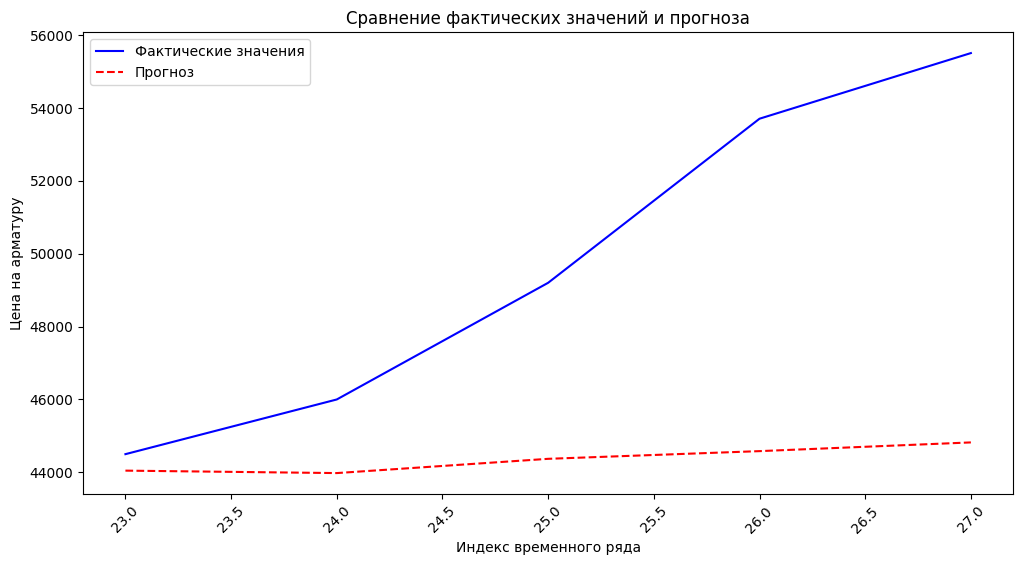

In [ ]:
# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(X_val.index, y_val, label="Фактические значения", color='blue')
plt.plot(X_val.index, y_pred, label="Прогноз", color='red', linestyle='--')
plt.xlabel("Индекс временного ряда")
plt.ylabel("Цена на арматуру")
plt.title("Сравнение фактических значений и прогноза")
plt.legend()
plt.xticks(rotation=45)
plt.show()